# Object segmentation

This notebook contains simple example of object segmentation using autoencoder idea based on VGG architecture

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

There are path for models. One for restore and one for saving

In [2]:
restore_model_from = None
save_model_to = './Models/Segmentation/vgg16-segmentation'

## Matplotlib visualization

In this notebook we are going to work with object masks. When we have worked with object detection (bounding box) we just draw rectangle around object. With mask we can plot pair of images - image and mask but it isn't so cool. The best way (for mee, maybe not for you) - plot mask over image using alpha channel. But for pretty cool visualization we need to create custom color map

In [3]:
from matplotlib.colors import LinearSegmentedColormap
ncolors = 2
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

plt.register_cmap(cmap=map_object)

## Data exploration

Dataset provides mask for some images. This mask contains 3 flags: 1 - foreground, 2 - background, 3 - unknown. The last flag is suitable for object countour (e.g. cat wool). Let's visualize all three masks over original image

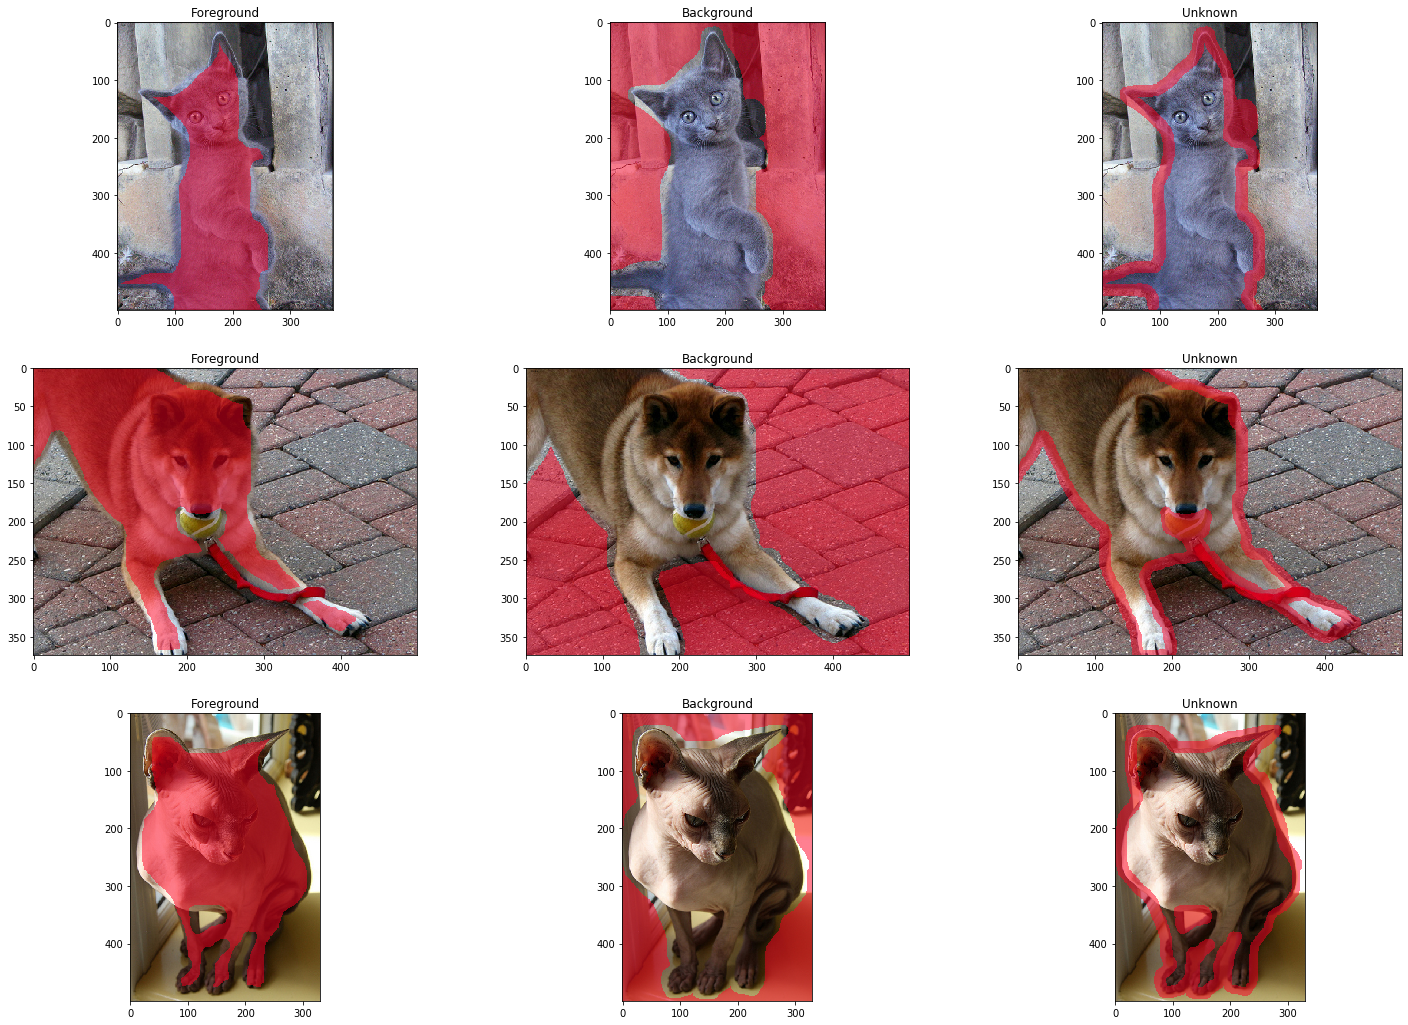

In [4]:
df = pd.read_csv('./Data/CatVsDog/dataset.csv')
df = df.sample(frac=1)

nrows = 3

fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(25, 6*nrows))
ax = ax.flatten()

for i, (idx, sample) in enumerate(df.sample(nrows).iterrows()):
    img = cv2.imread(sample['file'])
    mask_matrix = cv2.imread(sample['mask_file'], cv2.IMREAD_GRAYSCALE)
    mask_foreground = np.zeros_like(mask_matrix)
    mask_background = np.zeros_like(mask_matrix)
    mask_unknown = np.zeros_like(mask_matrix)
    mask_foreground[mask_matrix == 1] = 1
    mask_background[mask_matrix == 2] = 1
    mask_unknown[mask_matrix == 3] = 1
    
    ax[i*3].imshow(img[:, :, ::-1])
    ax[i*3].imshow(mask_foreground, cmap='rainbow_alpha', alpha=0.5)
    ax[i*3].set_title('Foreground')
    
    ax[i*3+1].imshow(img[:, :, ::-1])
    ax[i*3+1].imshow(mask_background, cmap='rainbow_alpha', alpha=0.5)
    ax[i*3+1].set_title('Background')
    
    ax[i*3+2].imshow(img[:, :, ::-1])
    ax[i*3+2].imshow(mask_unknown, cmap='rainbow_alpha', alpha=0.5)
    ax[i*3+2].set_title('Unknown')

## PyTorch dataset

Now, it's time to create dataset!

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SegmentationDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe, dsize=(224,224)):
        self.dataframe = dataframe[~dataframe.xmin.isna()].sample(frac=1).copy()
        self.dsize = dsize
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        img = cv2.imread(sample['file'])
        mask_matrix = cv2.imread(sample['mask_file'], cv2.IMREAD_GRAYSCALE)
        
        mask_f = np.zeros_like(mask_matrix)
        mask_b = np.zeros_like(mask_matrix)
        mask_u = np.zeros_like(mask_matrix)
        mask_f[mask_matrix==1] = 1
        mask_b[mask_matrix==2] = 1
        mask_u[mask_matrix==3] = 1
        mask = np.clip(mask_f+mask_u, 0, 1)
        
        mask = SegmentationDataset.preprocess_mask(mask, self.dsize)
        img = SegmentationDataset.preprocess_img(img, self.dsize)
        return img, mask
    
    @staticmethod
    def preprocess_img(img, dsize=(224,224)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img /= 255
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)
    
    @staticmethod
    def preprocess_mask(mask, dsize=(224,224)):
        mask = cv2.resize(mask, dsize)
        mask = mask.astype(np.uint8)
        mask = np.expand_dims(mask, axis=0)
        return torch.Tensor(mask)


Split train and test dataset

In [6]:
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]
dataset = SegmentationDataset(train_df)
test_dataset = SegmentationDataset(test_df)

## Model

This model use VGG16 architecture as backbone. VGG16 have benn already pretrained on imagenet. We need to implement transpose convolution part of network by ourself. Instead of coping full VGG architecture in reverse order, let's create only one layer (transpose convolution) for each corresponded VGG block. Here we go

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.extr =  nn.Sequential(*list(models.vgg16(pretrained=True).children())[:-1])
        
        self.conv_t_1_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, padding=0, stride=2)
        self.conv_t_2_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, padding=0, stride=2)
        self.conv_t_3_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, padding=0, stride=2)
        self.conv_t_4_1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv_t_5_1 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, padding=0, stride=2)
        
    def forward(self, x, bs):
        
        x = self.extr(x)
        x = F.relu(self.conv_t_1_1(x))
        x = F.relu(self.conv_t_2_1(x))
        x = F.relu(self.conv_t_3_1(x))
        x = F.relu(self.conv_t_4_1(x))
        x = self.conv_t_5_1(x)
        x = torch.sigmoid(x)
        return x


net = Net()
net.to(device);
if restore_model_from is not None:
    net.load_state_dict(torch.load(restore_model_from))

Here are some utils and metrics. Our metric is *pixelwise accuracy*

In [8]:
def tensor_to_numpy(t):
     return t.to('cpu').detach().numpy()
    
def pixelwise_accuracy(out, gt):
    out = tensor_to_numpy(out)
    gt = tensor_to_numpy(gt)
    out[out>0.5] = 1
    out[out<=0.5] = 0
    return np.mean(out==gt)

## Train step

In [9]:
def train_step(dataloader, batch_size):
    running_loss = 0.0
    px_acc = []
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs, batch_size)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        for j in range(batch_size):
            px_acc.append(pixelwise_accuracy(outputs[j], labels[j]))

        running_loss += loss.item()
    total_loss = running_loss / i
    return total_loss, np.mean(px_acc)

## Test step

In [10]:
def test_step(dataloader, batch_size):
    running_loss = 0.0
    px_acc = []
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs, batch_size)
            
        loss = criterion(outputs, labels)
        loss.backward()
        
        for j in range(batch_size):
            px_acc.append(pixelwise_accuracy(outputs[j], labels[j]))

        running_loss += loss.item()
    total_loss = running_loss / i
    return total_loss, np.mean(px_acc)

## Train model

You should reach about 88% pixel accuracy in 30 epochs

In [11]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
batch_size = 16
epochs = 30
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, drop_last=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, drop_last=True)

train_log = {'loss': [], 'px_acc': []}
test_log = {'loss': [], 'px_acc': []}
for epoch in range(epochs):  # loop over the dataset multiple times
    start_train = time.time()
    train_loss, train_px_acc = train_step(trainloader, batch_size)
    start_test = time.time()
    test_loss, test_px_acc = test_step(testloader, batch_size)
    end_test = time.time()
    
    if save_model_to is not None and epoch > 2 and test_px_acc > np.max(test_log['px_acc']):
        torch.save(net.state_dict(), '{}-{}-{:0.4f}px_acc'.format(save_model_to, epoch, test_px_acc))
    
    train_log['loss'].append(train_loss)
    train_log['px_acc'].append(train_px_acc)
    test_log['loss'].append(test_loss)
    test_log['px_acc'].append(test_px_acc)
    print('{} | Loss: {:0.6f}, {:0.6f} | Pixel Acc: {:0.4f}, {:0.4f} \t Train step: {:0.2f}s Test step: {:0.2f}s '.format(epoch, train_loss, test_loss, train_px_acc, test_px_acc,
                                                                                                               start_test-start_train, end_test-start_test))
                
print('Finished Training')

0 | Loss: 0.683827, 0.681150 | Pixel Acc: 0.5870, 0.5871 	 Train step: 23.57s Test step: 23.35s 
1 | Loss: 0.679994, 0.679110 | Pixel Acc: 0.5869, 0.5870 	 Train step: 23.76s Test step: 23.48s 
2 | Loss: 0.678810, 0.678574 | Pixel Acc: 0.5868, 0.5867 	 Train step: 23.86s Test step: 23.58s 
3 | Loss: 0.678335, 0.678146 | Pixel Acc: 0.5870, 0.5872 	 Train step: 23.94s Test step: 23.67s 
4 | Loss: 0.678232, 0.678064 | Pixel Acc: 0.5868, 0.5871 	 Train step: 23.85s Test step: 23.63s 
5 | Loss: 0.678068, 0.678025 | Pixel Acc: 0.5870, 0.5870 	 Train step: 23.84s Test step: 23.64s 
6 | Loss: 0.678084, 0.677966 | Pixel Acc: 0.5867, 0.5870 	 Train step: 23.91s Test step: 23.58s 
7 | Loss: 0.678062, 0.677986 | Pixel Acc: 0.5866, 0.5868 	 Train step: 23.94s Test step: 23.63s 
8 | Loss: 0.677886, 0.678030 | Pixel Acc: 0.5870, 0.5865 	 Train step: 23.95s Test step: 23.59s 
9 | Loss: 0.677891, 0.677871 | Pixel Acc: 0.5869, 0.5868 	 Train step: 23.94s Test step: 23.61s 
10 | Loss: 0.677822, 0.677797 

Visualize train process

Text(0.5, 1.0, 'Pixel Accuracy History')

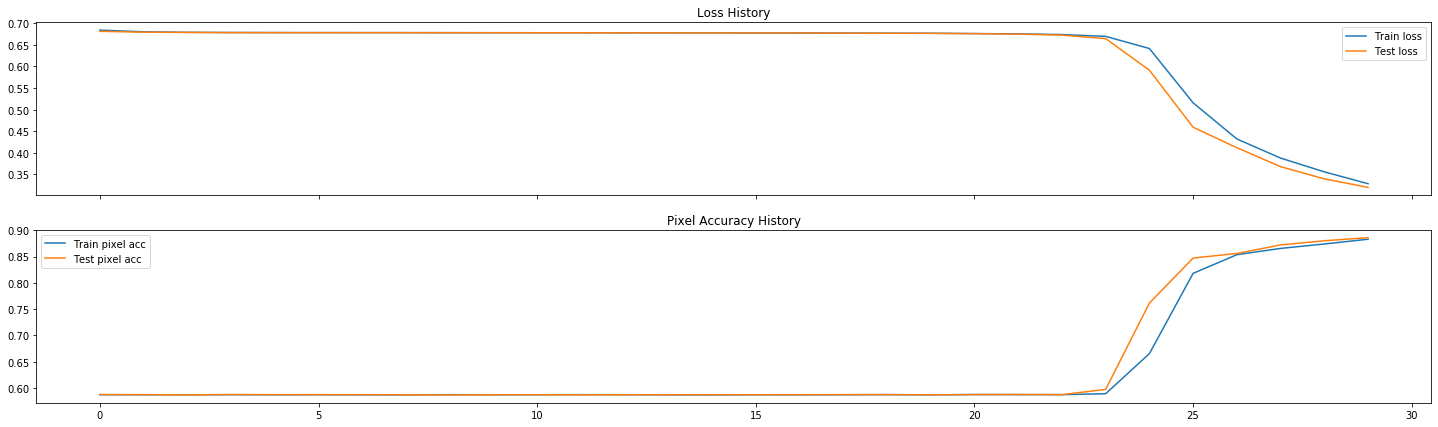

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(25, 7), sharey=False, sharex=True)
ax[0].plot(np.arange(0, epochs, 1), train_log['loss'], label='Train loss')
ax[0].plot(np.arange(0, epochs, 1), test_log['loss'], label='Test loss')
ax[1].plot(np.arange(0, epochs, 1), train_log['px_acc'], label='Train pixel acc')
ax[1].plot(np.arange(0, epochs, 1), test_log['px_acc'], label='Test pixel acc')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Loss History')
ax[1].set_title('Pixel Accuracy History')

## Save model

In [13]:
if save_model_to is not None:
    torch.save(net.state_dict(), save_model_to)

## Visualize some test samples

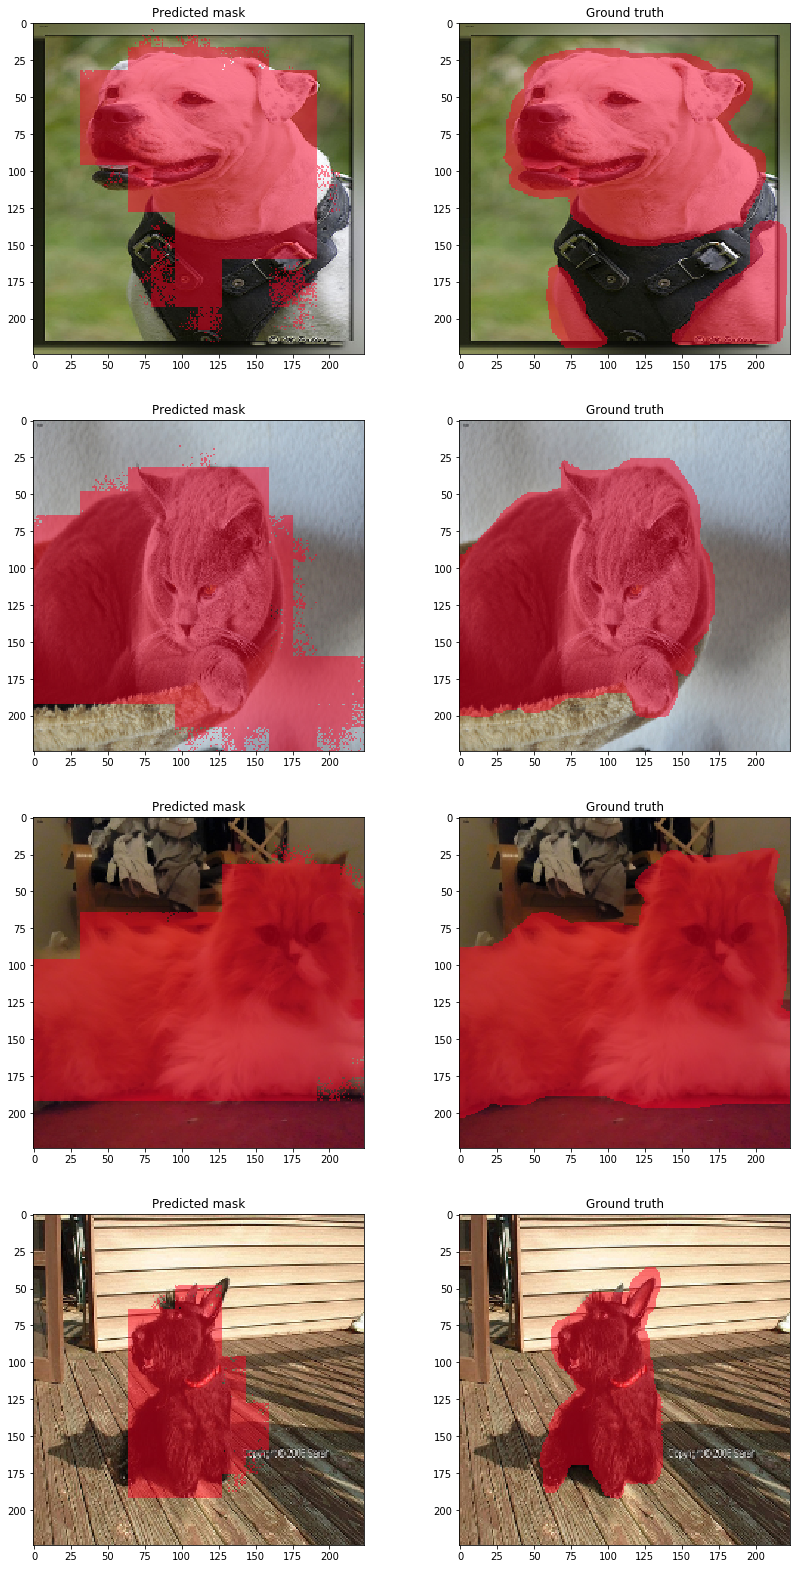

In [14]:
ncols = 1
nrows = 4
not_tested = df[~df.xmin.isna()]
fig, ax = plt.subplots(ncols=ncols*2, nrows=nrows, figsize=(ncols*14, 7*nrows))
ax = ax.flatten()

for vid, (idx, i) in enumerate(test_df[~test_df.xmin.isna()].sample(ncols*nrows).iterrows()):
    img = cv2.imread(i['file'])
    ipt = SegmentationDataset.preprocess_img(img)
    ipt = ipt.unsqueeze(0)
    ipt = ipt.to(device)
    pred = net(ipt, 1)
    
    mask_matrix = cv2.imread(i['mask_file'], cv2.IMREAD_GRAYSCALE)
    mask_gt = np.zeros_like(mask_matrix)
    mask_gt[(mask_matrix == 3) | (mask_matrix == 1)] = 1
    mask_gt = cv2.resize(mask_gt, (224, 224))
    mask_gt[mask_gt>0.5] = 1
    mask_gt[mask_gt<=0.5] = 0
    
    pred = pred.to('cpu').detach().numpy()
    pred = pred[0][0]
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    resized_sample = cv2.resize(img, (224,224))
    ax[vid*2].imshow(resized_sample[:, :, ::-1])
    ax[vid*2].imshow(pred, cmap='rainbow_alpha', alpha=0.5)
    ax[vid*2].set_title('Predicted mask')
    
    ax[vid*2+1].imshow(resized_sample[:, :, ::-1])
    ax[vid*2+1].imshow(mask_gt, cmap='rainbow_alpha', alpha=0.5)
    ax[vid*2+1].set_title('Ground truth')